# This notebook contains the cluster analysis presented at the RSSB meeting in Brussels on 14 June 2022

## The data + additional analysis scripts are linked to in the readme in this repo

In [1]:
import re
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
# import colorcet as cc
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [15, 10]
sns.set(style='darkgrid')

In [2]:
# note: you'll need matplot lib >= 3.4
import matplotlib
matplotlib.__version__


'3.4.1'

In [3]:
# to read back in:
# NOTE CHANGE THE DIRECTORY HERE TO WHEREVER THE DATA FILE IS STORED
in_dir = '/home/Data/'
with open(in_dir + 'omnibus_jobs_df.pickle', 'rb') as handle:
    omnibus_jobs_df = pickle.load(handle)
omnibus_jobs_df.shape

(6590, 29)

In [4]:
# look at a random sample of 7 observations
omnibus_jobs_df.sample(7)

,employer_id,company_name,job_id,job_title,job_function,job_description_text,job_skills,education_desired,job_location,company_hq_location,company_sector_name,company_industry,company_type,company_size,company_revenue,company_year_founded,company_website,rating_global,rating_comp_ben,rating_culture_values,rating_career_opportunities,rating_w_life_balance,rating_sr_mgt,query_country,date_job_posted,date_job_expires,age_job_posting_days,scraping_date,language
2878,297002f545992ca2ee569085e3f9c199,Brit Insurance Holdings NV,6476ce744f18712958099ff744d91708,Senior Data Scientist,data scientist,Benefits We reward excellent performance with ...,"[TensorFlow, Google Cloud Platform, Analysis s...","[Doctoral degree, Bachelor's degree]","London, England","London, United Kingdom",Insurance,Insurance Carriers,Company - Private,501 to 1000 Employees,$2 to $5 billion (USD),1999.0,www.britinsurance.com,4.1,4.1,4.0,3.6,3.8,NaN,united_kingdom,2021-08-06,2021-09-18,12,2021-08-19,en
934,1b166a0e1473a7e91720e9e6993002ac,Landwirtschaftsverlag Gmbh,2a8b41911cf172b854edd7ac5c72fc58,Data Scientist (m/w/d),data scientist,Unser Leben ist ein Ponyhof! Du willst ein Tei...,"[R, SQL, PHP, Python]",[],Germany,"Münster, Germany",NaN,NaN,Unknown,501 to 1000 Employees,$100 to $500 million (USD),1946.0,www.lv.de,NaN,NaN,NaN,NaN,NaN,NaN,germany,2021-08-06,2021-09-18,12,2021-08-19,de
2699,94d13b31e365d1de3432b039961d78cc,Space Ape Games Limited,f2460c00a5b9a6991bf449c039c4e759,Data Scientist,data scientist,We are looking for a data scientist to join ou...,"[R, Data analysis skills, Tableau, SQL, Python]",[],"London, England","London, United Kingdom",Media,Video Games,Company - Private,51 to 200 Employees,$50 to $100 million (USD),2012.0,www.spaceapegames.com,4.7,4.5,4.8,4.3,4.6,NaN,united_kingdom,2021-08-10,2021-09-18,8,2021-08-19,en
3102,35db7d54c7f3262c8a0acf001eebde0e,D-Data,0fd19997fd0faa4572d0dafc584f1745,Chapter Lead Data Engineering (Azure),data engineer,"D-Data is een jong bedrijf, met grootse planne...","[Azure, Spark, Dutch]",[Master's degree],Amsterdam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,netherlands,2021-08-16,2021-09-18,2,2021-08-19,nl
4177,6608d8cb0d3ffc54c387ef2dec83f262,YoungCapital B.V.,b75e3ef246b980b43bbbbbb178f0daf0,Data analist,data analyst,Ben jij op zoek naar een nieuwe uitdaging in d...,[],[Bachelor's degree],Amsterdam,"Hoofddorp, Netherlands",Business Services,Staffing & Outsourcing,Company - Private,1001 to 5000 Employees,$100 to $500 million (USD),2000.0,www.youngcapital.nl,3.5,3.1,3.9,3.3,3.8,NaN,netherlands,2021-11-17,2021-12-26,8,2021-11-26,nl
608,408603c58c500979542d049e2b01b94f,Saint-Etienne Tourisme et Congrès,db361b938554726f4648087218ba53fd,"Data Analyst, chargé(e) d'étudeset de prospective",data analyst,"Piloter le dispositif d'aide à la décision, en...",[],[],Saint-Étienne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,france,2021-09-07,2021-10-17,9,2021-09-17,fr
3664,55d42e2928625adf5b484dc1824888b3,Yacht Technology,5c81e464878aab88384ebe8173025b12,KYC Data Scientist,data scientist,Bedrijfsomschrijving When you choose for Yacht...,[],[],Netherlands,"Diemen, Netherlands",Business Services,Staffing & Outsourcing,Subsidiary or Business Segment,1001 to 5000 Employees,$100 to $500 million (USD),NaN,www.yacht.nl,3.0,3.2,2.5,2.5,3.3,NaN,netherlands,2021-11-10,2021-12-12,1,2021-11-12,en


In [5]:
omnibus_jobs_df.query_country.value_counts()

united_kingdom    1661
germany           1658
france            1504
netherlands        869
belgium            440
ireland            394
luxembourg          64
Name: query_country, dtype: int64

In [6]:
# look at a randomly selected job description text
# (note - they are not all in English!)
[x for x in omnibus_jobs_df.job_description_text.sample(1)]

["Le Groupe Carrefour est le leader de la grande distribution en Europe avec plus de 115 000 collaborateurs en France et une forte présence à l’international. Avec plus de 300 métiers, Carrefour trouve son dynamisme à travers la richesse et la diversité de ses équipes. L’utilisation de la data et le développement des capacités analytiques sont un axe majeur du plan stratégique du Groupe à horizon 2027. Directement rattachée au COMEX France, l’Analytics Factory de Carrefour France est le pilier de cette transformation analytique, au service de l’ensemble des équipes métier de Carrefour France – Marketing, Marchandises, Exploitation, E-commerce, Supply Chain, Services Financiers, etc. Les data scientists, data engineers, spécialistes data viz et data governance de la direction accompagnent au quotidien les équipes métier pour améliorer l’excellence opérationnelle (automatisation de processus, démocratisation de l’accès à la donnée, développement de la culture analytique), pour optimiser 

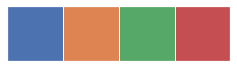

In [7]:
# set up custom color palette to ensure roles have consistent colors in plots below
role_dict = ['data scientist', 'data engineer', 'data analyst', 'machine learning engineer']
custom_palette = sns.color_palette("deep", 4) # deep
role_palette = dict(zip(role_dict, custom_palette))
sns.palplot(custom_palette)

# Cluster map of job functions based on employer-determined keyword list

In [8]:
# make a dummy dataframe for the skills
# 1 row per job ad, with skills in the columns
# and 1/0 for presence/absence of the skill in the ad
# https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
def prepare_binarized_dummies_from_skills(df_f, skills_col_f, job_fn_col_f):
    # prepare matrix of dummies - one col per skill, 0/1 for absence/presence
    doc_perc_skills = pd.DataFrame(mlb.fit_transform(df_f[skills_col_f]),columns=mlb.classes_, index=df_f.index)
    # num rows in orig input matrix
    num_rows_input = doc_perc_skills.shape[0]
    print('number of rows in input data:')
    print(num_rows_input)
    total_num_skills = doc_perc_skills.shape[1]
    print('total number of skills in input data:')
    print(total_num_skills)
    # print('skills in input data:')
    # print([x for x in doc_perc_skills.columns])
    return(doc_perc_skills)


    

In [9]:
dummy_df = prepare_binarized_dummies_from_skills(omnibus_jobs_df, 'job_skills', 'job_function')

number of rows in input data:
6590
total number of skills in input data:
341


In [10]:
dummy_df.head()

,.NET,.NET Core,4G/LTE,5G,ABAP,AJAX,APIs,ASP,ASP.NET,AWS,Accounting,Active Directory,Administrative experience,Adobe Analytics,Adobe Campaign,Agile,Agriculture,Alteryx,Analysis skills,Analytics,Android,Angular,Ansible,Ant,Apache,Apache Hive,Apache Pig,Application development,Arabic,ArcGIS,Assembly,Auditing,Avaya,Azure,B2B,Backbone.js,Bamboo,Banking,Big data,Bilingual,Bloomberg,Bootstrap,Business analysis,Business development,Business intelligence,Business requirements,C,C#,C++,CAD,CI/CD,CRM software,CSS,Cassandra,CentOS,Chef,Chinese,Clojure,Cloud architecture,Cloud computing,Cognos,Communication skills,Computer literacy,Computer networking,Computer science,Computer skills,Computer vision,Confluence,Construction,Continuous integration,Copywriting,Crystal Reports,Customer service,Cybersecurity,D3.js,DB2,Data analysis skills,Data analytics,Data collection,Data mining,Data modeling,Data science,Data warehouse,Database administration,Database management,Database marketing,Databases,Debian,Debugging,Deep learning,Dementia care,Digital marketing,Distributed systems,Django,Docker,Driving,Drupal,Dutch,DynamoDB,E-commerce,ECMAScript,ERP systems,Elasticsearch,Electrical engineering,Electrical experience,Email marketing,English,Erlang,Express.js,FTP,FileMaker,Financial acumen,Financial services,Firewall,Fortran,French,German,Git,GitHub,GitLab,Go,Google AdWords,Google Ads,Google Analytics,Google Cloud Platform,Google Docs,Google Suite,Google Tag Manager,GraphQL,HBase,HRIS,HTML5,HTTPS,Hadoop,Haskell,Heavy lifting,Heroku,Hospitality,HubSpot,Human resources,IIS,IP networking,IT,IaaS,Identity & access management,Image processing,Informatica,Internet of things,Italian,JD Edwards,JDBC,JSON,JSP,JUnit,Java,JavaScript,Jenkins,Jira,Kafka,Korean,Kubernetes,LabView,Leadership,Linux,Load balancing,Logistics,Lucene,MATLAB,Mac OS,Machine learning,MailChimp,Maintenance,Management,Manufacturing,Marketing,Math,Maven,Mechanic experience,Mechanical knowledge,Mentoring,Merchandising,Mesos,MicroStation,Microsoft Access,Microsoft Dynamics Navision,Microsoft Excel,Microsoft Office,Microsoft Outlook,Microsoft Powerpoint,Microsoft Project,Microsoft SQL Server,Microsoft Windows Server,Microsoft Word,Minitab,MongoDB,MySQL,NFS,NIS,Natural language processing,Neo4j,NetSuite,Network architecture,NoSQL,Node.js,Norwegian,OBIEE,OOP,Objective-C,OpenStack,Operating systems,Oracle,Organizational skills,PHP,PL/SQL,PaaS,Pardot,Pegasystems,Pentaho,PeopleSoft,Perforce,Perl,Pivot tables,Polish,Portuguese,PostgreSQL,Power BI,PowerShell,Presentation skills,Process management,Product development,Project management,Project planning,Public speaking,Puppet,Purchasing,Python,QlikView,Qualitative analysis,Quality assurance,QuickBooks,R,React,React Native,Redis,Redshift,Relational databases,Requirements gathering,Research,Restaurant experience,Revit,Root cause analysis,Ruby,Russian,Rust,S3,SAFe,SAP,SAP BW 4HANA,SAP BusinessObjects,SAP ERP,SAP HANA,SAP S/4HANA,SAP SuccessFactors,SAP Supply Chain Management,SAS,SCCM,SEO,SOAP,SPARQL,SPSS,SQL,SQL Server Management Studio,SSIS,SVN,Sage,Sales,Salesforce,Salesforce Marketing Cloud,Scala,Schematics,Scripting,Scrum,Selenium,ServiceNow,SharePoint,Shell Scripting,Smartsheet,Social media management,Social media marketing,Software architecture,Software deployment,Software development,Software testing,Solr,Spanish,Spark,Splunk,Spring,Stata,Statistical software,Statistics,Supervising experience,Surveillance,Swedish,Swift,T-SQL,TFS,Tableau,Teaching,Team management,TensorFlow,Teradata,Terraform,Time management,Tomcat,Turkish,Tutoring,TypeScript,Typing,UML,UX,Ubuntu,Unity,Unreal Engine,Visio,Visual Basic,Visual Studio,WAN,Warehouse experience,Warehouse management system,Web development,Windows,WordPress,Workday,Writing skills,XML,XSLT,Xero,Yardi,iOS,jQuery
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [11]:
# dictionary for aggregation of certain skills into higher-level groupings
skill_aggregation_dict = {"ASP":['ASP', 'ASP.NET'],
".NET": ['.NET', '.NET Core'],
"Apache": [ 'Apache', 'Apache Hive', 'Apache Pig'],
"Language skills (e.g. English, French, etc.)":['Arabic','Bilingual', 'Chinese',  'Dutch', 'English', 'French', 'German', 'Italian', 'Korean', 'Norwegian',  'Polish','Turkish',  'Portuguese', 'Russian',  'Spanish', 'Swedish' ],
"Cloud platforms (e.g. AWS, GCP, etc.)": [ 'Azure', 'AWS',  'Google Cloud Platform', 'S3', 'Cloud architecture', 'Cloud computing'],
"C":['C', 'C#', 'C++'],
"Data analysis": ['Data analysis skills', 'Analysis skills', 'Data analytics', 'Analytics'],
"Databases": [ 'Data warehouse', 'Database administration', 'Database management', 'Databases'],
"Git":['Git', 'GitHub', 'GitLab'],
"Java":['Java', 'JavaScript'],
"Mentoring":['Mentoring','Tutoring', 'Teaching'],
"Microsoft Office Suite":['Microsoft Excel', 'Microsoft Office', 'Microsoft Outlook', 'Microsoft Powerpoint','Microsoft Word'],
"Google Suite":[ 'Google Docs', 'Google Suite'],
"Google Ads": ['Google AdWords', 'Google Ads', 'Google Analytics', 'Google Tag Manager'], 
"SQL":['MySQL', 'PostgreSQL', 'SQL', 'SQL Server Management Studio', 'Microsoft SQL Server' ],
"SAP": ['SAP', 'SAP BW 4HANA', 'SAP BusinessObjects', 'SAP ERP', 'SAP HANA', 'SAP S/4HANA', 'SAP SuccessFactors', 'SAP Supply Chain Management' ],
"React":['React', 'React Native' ],
"Salesforce":['Salesforce', 'Salesforce Marketing Cloud'],
"Linux":['Linux', 'Ubuntu','Debian'],
"Social media":[ 'Social media management', 'Social media marketing'],
"Marketing analytics":['Email marketing', 'Database marketing' ]}

In [12]:
# from the above dictionary, get a flat list of all the skills that will be aggregated
# we will use these to subset the dummy df for the aggregations
value_list = []
for key, value in skill_aggregation_dict.items():
    value_list.append(value)
aggregated_skills = [item for sublist in value_list for item in sublist]
# aggregated_skills

In [13]:
# aggregate the skills using the dictionary
# put the aggregated skills back into dummy df
def aggregate_skills(dummy_df_f, aggregated_skills_f, skill_aggregation_dict_f):
    # we make new df only containing the columns we will aggregate
    # this db will be used to do the additions
    df_to_agg_f = dummy_df_f[aggregated_skills_f]
    # remove aggregation cols from original dummy df
    dummy_trim_df_f = dummy_df_f.drop(columns = aggregated_skills_f)
    # loop through the dictionary and add aggregated columns to original (now trimmed) dummy df
    for key, value in skill_aggregation_dict_f.items():
        dummy_trim_df_f[key] = df_to_agg_f[value].sum(axis=1)
    # make it binary again (summed cols can be greater than 1)
    # THERE MUST BE A BETTER WAY OF DOING THIS (suggestions welcome!)
    dummy_trim_df_f = pd.DataFrame(np.where(dummy_trim_df_f >=1,1, 0), columns = dummy_trim_df_f.columns)
    return(dummy_trim_df_f)


In [14]:
cleaned_skills_df = aggregate_skills(dummy_df, aggregated_skills, skill_aggregation_dict)
cleaned_skills_df.shape

(6590, 279)

In [15]:
cleaned_skills_df.head()

,4G/LTE,5G,ABAP,AJAX,APIs,Accounting,Active Directory,Administrative experience,Adobe Analytics,Adobe Campaign,Agile,Agriculture,Alteryx,Android,Angular,Ansible,Ant,Application development,ArcGIS,Assembly,Auditing,Avaya,B2B,Backbone.js,Bamboo,Banking,Big data,Bloomberg,Bootstrap,Business analysis,Business development,Business intelligence,Business requirements,CAD,CI/CD,CRM software,CSS,Cassandra,CentOS,Chef,Clojure,Cognos,Communication skills,Computer literacy,Computer networking,Computer science,Computer skills,Computer vision,Confluence,Construction,Continuous integration,Copywriting,Crystal Reports,Customer service,Cybersecurity,D3.js,DB2,Data collection,Data mining,Data modeling,Data science,Debugging,Deep learning,Dementia care,Digital marketing,Distributed systems,Django,Docker,Driving,Drupal,DynamoDB,E-commerce,ECMAScript,ERP systems,Elasticsearch,Electrical engineering,Electrical experience,Erlang,Express.js,FTP,FileMaker,Financial acumen,Financial services,Firewall,Fortran,Go,GraphQL,HBase,HRIS,HTML5,HTTPS,Hadoop,Haskell,Heavy lifting,Heroku,Hospitality,HubSpot,Human resources,IIS,IP networking,IT,IaaS,Identity & access management,Image processing,Informatica,Internet of things,JD Edwards,JDBC,JSON,JSP,JUnit,Jenkins,Jira,Kafka,Kubernetes,LabView,Leadership,Load balancing,Logistics,Lucene,MATLAB,Mac OS,Machine learning,MailChimp,Maintenance,Management,Manufacturing,Marketing,Math,Maven,Mechanic experience,Mechanical knowledge,Merchandising,Mesos,MicroStation,Microsoft Access,Microsoft Dynamics Navision,Microsoft Project,Microsoft Windows Server,Minitab,MongoDB,NFS,NIS,Natural language processing,Neo4j,NetSuite,Network architecture,NoSQL,Node.js,OBIEE,OOP,Objective-C,OpenStack,Operating systems,Oracle,Organizational skills,PHP,PL/SQL,PaaS,Pardot,Pegasystems,Pentaho,PeopleSoft,Perforce,Perl,Pivot tables,Power BI,PowerShell,Presentation skills,Process management,Product development,Project management,Project planning,Public speaking,Puppet,Purchasing,Python,QlikView,Qualitative analysis,Quality assurance,QuickBooks,R,Redis,Redshift,Relational databases,Requirements gathering,Research,Restaurant experience,Revit,Root cause analysis,Ruby,Rust,SAFe,SAS,SCCM,SEO,SOAP,SPARQL,SPSS,SSIS,SVN,Sage,Sales,Scala,Schematics,Scripting,Scrum,Selenium,ServiceNow,SharePoint,Shell Scripting,Smartsheet,Software architecture,Software deployment,Software development,Software testing,Solr,Spark,Splunk,Spring,Stata,Statistical software,Statistics,Supervising experience,Surveillance,Swift,T-SQL,TFS,Tableau,Team management,TensorFlow,Teradata,Terraform,Time management,Tomcat,TypeScript,Typing,UML,UX,Unity,Unreal Engine,Visio,Visual Basic,Visual Studio,WAN,Warehouse experience,Warehouse management system,Web development,Windows,WordPress,Workday,Writing skills,XML,XSLT,Xero,Yardi,iOS,jQuery,ASP,.NET,Apache,"Language skills (e.g. English, French, etc.)","Cloud platforms (e.g. AWS, GCP, etc.)",C,Data analysis,Databases,Git,Java,Mentoring,Microsoft Office Suite,Google Suite,Google Ads,SQL,SAP,React,Salesforce,Linux,Social media,Marketing analytics
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0

# original clustermap

In [16]:
# subset the dummy df columns to those skills that appear a certain amount of times
# the threshold for the subset is a parameter (threshold_f)
# below, we subset on 50 times
# then, aggregate by role and calculate the percentage of 
# job ads per role that contain each skill
def subset_cleaned_skills(cleaned_skills_df_f, threshold_f, orig_df_f, job_fn_col_f):
    # make column with total keywords
    cleaned_skills_df_f['total_keywords'] = cleaned_skills_df_f.sum(axis=1)
    # subset columns - only those skills that appear more times than threshold
    cleaned_skills_df_subset_f = cleaned_skills_df_f.loc[:, cleaned_skills_df_f.sum(axis=0) > threshold_f]
    print('shape of matrix when only keeping those that appear more times than the threshold')
    print(cleaned_skills_df_subset_f.shape)
    # add job function from original df
    cleaned_skills_df_subset_f = cleaned_skills_df_subset_f.join(orig_df_f[job_fn_col_f])
    # remove rows with no keywords
    final_subset_f = cleaned_skills_df_subset_f[cleaned_skills_df_subset_f['total_keywords']> 0].reset_index(drop = True)
    num_rows_input = cleaned_skills_df_f.shape[0]
    final_num_rows = final_subset_f.shape[0]
    final_num_skills = final_subset_f.shape[1]
    print('number of rows with no skills')
    print(num_rows_input - final_num_rows)
    print('percentage of rows with at least 1 skill')
    print((final_num_rows/num_rows_input) * 100)
    print('final number of skills retained:')
    print(final_subset_f.shape[1])
    print('final number of rows retained:')
    print(final_num_rows)
    print('avg number of skills / job ad (only ads with at least 1 skill):')
    print(final_subset_f.total_keywords.sum() / final_subset_f.shape[0])
    return(final_subset_f)

In [17]:
final_subset_df = subset_cleaned_skills(cleaned_skills_df, 50, omnibus_jobs_df, ['job_function', 'job_id'])
final_subset_df.shape

shape of matrix when only keeping those that appear more times than the threshold
(6590, 53)
number of rows with no skills
873
percentage of rows with at least 1 skill
86.752655538695
final number of skills retained:
55
final number of rows retained:
5717
avg number of skills / job ad (only ads with at least 1 skill):
3.9616931957320274


(5717, 55)

In [18]:
final_subset_df.head()

,APIs,Agile,Ansible,Big data,Business intelligence,Communication skills,Data mining,Docker,Elasticsearch,Go,HTML5,Hadoop,IT,Jenkins,Jira,Kafka,Kubernetes,Leadership,MATLAB,Marketing,MongoDB,Natural language processing,NoSQL,Node.js,Oracle,Power BI,Presentation skills,Python,R,Redshift,Relational databases,SAS,Scala,Shell Scripting,Software development,Spark,Tableau,TensorFlow,Terraform,.NET,Apache,"Language skills (e.g. English, French, etc.)","Cloud platforms (e.g. AWS, GCP, etc.)",C,Data analysis,Databases,Git,Java,Microsoft Office Suite,Google Ads,SQL,Linux,total_keywords,job_function,job_id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,data analyst,c6d6dd9bfda01c04aaee353b9614f2c0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,data scientist,ee883b2f81fd104f84b8773b10a51e64
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,machine learning engineer,be021587a7a2527dbebba4203b8dedd9
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,data engineer,b9d14f9a76c502c9c921ada2948fc963
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,data scientist,b507c27398401562cc2211a64e1c1dda


In [20]:
final_subset_df.total_keywords.value_counts()

3     1110
2     1037
1      861
4      797
5      626
6      425
7      320
8      214
9      123
10      74
11      45
12      25
13      19
14       9
16       9
18       6
15       6
17       5
19       2
20       2
23       1
21       1
Name: total_keywords, dtype: int64

In [21]:
def aggregate_cleaned_skills(final_subset_f):
    # drop job_id, which we'll need for the cluster exercise below
    # but which we don't need for the aggregation
    final_subset_f = final_subset_f.drop(['job_id', 'total_keywords'], axis = 1)
    # aggregate the data by job function (role) and calculate the percentage
    # of ads per role that contain each skill
    agg_df_f = final_subset_f.groupby(['job_function']).mean() * 100
    return(agg_df_f)

In [22]:
agg_df = aggregate_cleaned_skills(final_subset_df)
agg_df.shape

(4, 52)

In [23]:
agg_df.head()

,APIs,Agile,Ansible,Big data,Business intelligence,Communication skills,Data mining,Docker,Elasticsearch,Go,HTML5,Hadoop,IT,Jenkins,Jira,Kafka,Kubernetes,Leadership,MATLAB,Marketing,MongoDB,Natural language processing,NoSQL,Node.js,Oracle,Power BI,Presentation skills,Python,R,Redshift,Relational databases,SAS,Scala,Shell Scripting,Software development,Spark,Tableau,TensorFlow,Terraform,.NET,Apache,"Language skills (e.g. English, French, etc.)","Cloud platforms (e.g. AWS, GCP, etc.)",C,Data analysis,Databases,Git,Java,Microsoft Office Suite,Google Ads,SQL,Linux
job_function,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
data analyst,0.903226,2.193548,0.000000,0.387097,4.000000,17.354839,1.483871,0.516129,0.258065,0.129032,0.580645,1.806452,6.967742,0.129032,1.225806,0.129032,0.129032,1.419355,1.419355,2.387097,0.064516,0.064516,0.516129,0.064516,3.096774,25.870968,2.193548,34.387097,11.483871,1.161290,1.354839,6.387097,0.838710,0.387097,0.322581,2.064516,13.290323,0.709677,0.258065,0.322581,0.580645,24.000000,7.419355,1.741935,16.838710,4.838710,2.193548,2.580645,28.645161,2.516129,47.935484,0.451613
data engineer,3.707929,4.620650,2.167712,2.681118,1.711352,6.446092,0.399315,8.442670,2.852253,1.654307,1.369082,18.767827,3.308614,4.962921,3.479749,8.442670,5.533371,1.083856,1.140901,0.798631,3.137479,0.171135,3.137479,1.996577,2.452938,9.754706,0.285225,67.027952,6.617228,4.905876,0.969766,1.083856,16.600114,1.825442,1.369082,31.431831,5.761552,1.939532,5.875642,2.110667,6.560183,30.290930,32.915003,6.217912,2.167712,3.422704,9.469481,16.257844,2.224758,0.399315,50.770108,3.365659
data scientist,2.207862,2.046311,0.323102,1.130856,0.807754,13.354873,4.792676,3.877221,0.861605,0.807754,0.861605,9.369952,4.738826,1.400108,1.669359,0.700054,1.507808,2.423263,4.361874,1.130856,0.969305,0.753904,2.100162,0.538503,0.915455,8.508347,1.615509,79.644588,29.079160,0.700054,1.507808,6.946688,5.761982,1.023156,1.992461,16.585891,7.646742,9.693053,0.430802,0.915455,3.177167,30.640819,16.801292,8.023694,7.323640,2.477114,9.531502,8.562197,3.231018,0.323102,40.549273,2.261712
machine learning engineer,3.052065,4.129264,1.256732,0.359066,0.000000,7.540395,0.897666,10.233393,0.359066,1.615799,0.538600,6.822262,2.692998,3.770197,3.590664,1.615799,7.719928,0.897666,1.974865,0.359066,0.359066,6.822262,1.256732,1.256732,0.000000,0.538600,0.000000,84.201077,7.001795,0.359066,0.000000,0.000000,8.797127,3.052065,4.847397,15.619390,0.000000,33.034111,2.513465,0.718133,1.974865,27.109515,16.876122,25.134650,2.333932,0.897666,6.283662,16.696589,0.179533,0.179533,16.696589,3.052065


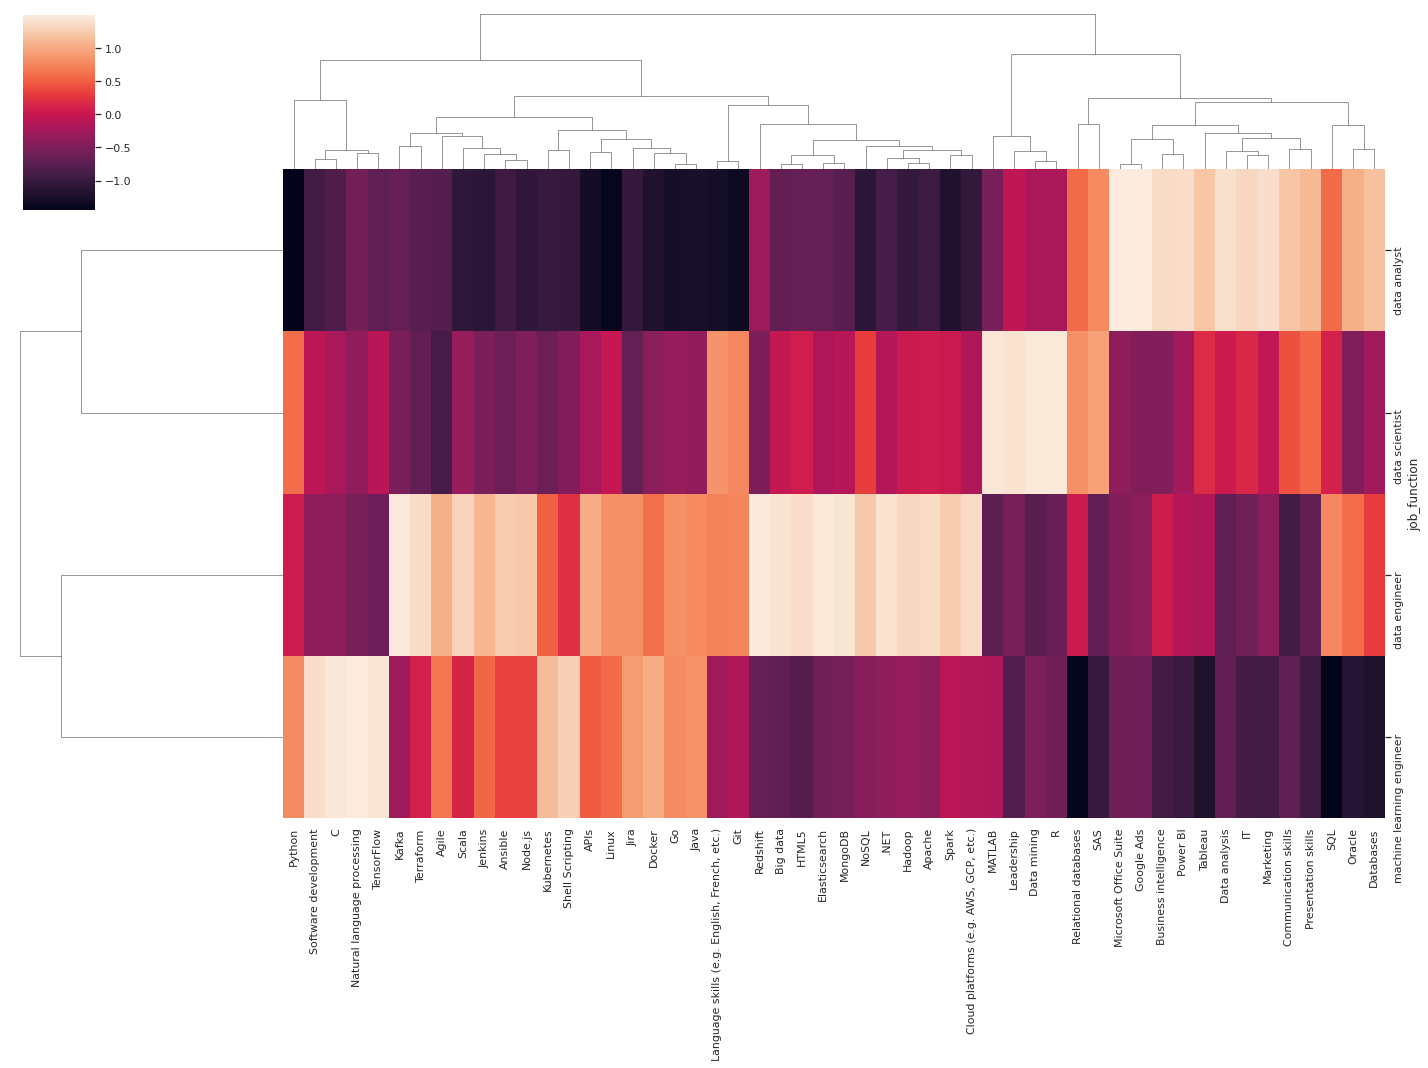

In [24]:
g = sns.clustermap(agg_df, z_score = 1, figsize=(20, 15))

# reproduce just the skills clustering - to extract clusters and their skills

In [25]:
import scipy
from matplotlib.pyplot import cm
from scipy.cluster import hierarchy
import matplotlib.colors as mcolors


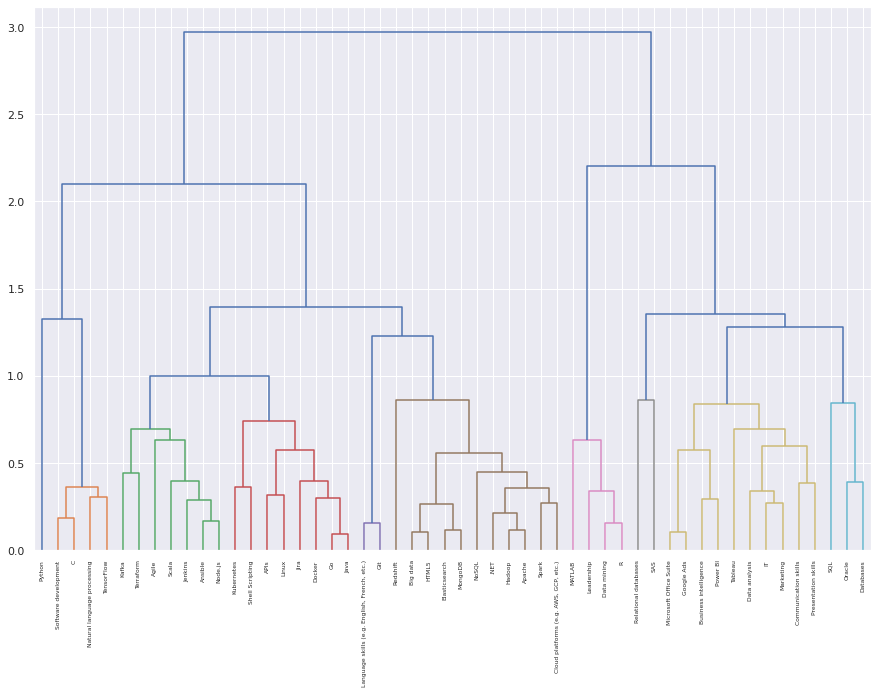

In [26]:
# recreate the clustering in the above clustermap
# for the skills
# cut the tree at .9 - gives 10 clusters and they seem
# logical for the most part
den = scipy.cluster.hierarchy.dendrogram(g.dendrogram_col.linkage,
                                         labels = agg_df.columns,
                                         color_threshold= .9 )

# Make Dictionary with skills for each cluster

In [27]:
from collections import defaultdict

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = {}
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes

In [28]:
clusters = get_cluster_classes(den)

In [29]:
clusters

{'C1': ['Software development',
  'C',
  'Natural language processing',
  'TensorFlow'],
 'C0': ['Python'],
 'C2': ['Kafka',
  'Terraform',
  'Ansible',
  'Node.js',
  'Jenkins',
  'Scala',
  'Agile'],
 'C3': ['Kubernetes',
  'Shell Scripting',
  'APIs',
  'Linux',
  'Go',
  'Java',
  'Docker',
  'Jira'],
 'C4': ['Language skills (e.g. English, French, etc.)', 'Git'],
 'C5': ['Big data',
  'HTML5',
  'Elasticsearch',
  'MongoDB',
  'Hadoop',
  'Apache',
  '.NET',
  'Spark',
  'Cloud platforms (e.g. AWS, GCP, etc.)',
  'NoSQL',
  'Redshift'],
 'C6': ['Data mining', 'R', 'Leadership', 'MATLAB'],
 'C7': ['Relational databases', 'SAS'],
 'C8': ['Microsoft Office Suite',
  'Google Ads',
  'Business intelligence',
  'Power BI',
  'IT',
  'Marketing',
  'Data analysis',
  'Communication skills',
  'Presentation skills',
  'Tableau'],
 'C9': ['Oracle', 'Databases', 'SQL']}

In [30]:
list(clusters.keys())

['C1', 'C0', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

In [31]:
clusters.values()

dict_values([['Software development', 'C', 'Natural language processing', 'TensorFlow'], ['Python'], ['Kafka', 'Terraform', 'Ansible', 'Node.js', 'Jenkins', 'Scala', 'Agile'], ['Kubernetes', 'Shell Scripting', 'APIs', 'Linux', 'Go', 'Java', 'Docker', 'Jira'], ['Language skills (e.g. English, French, etc.)', 'Git'], ['Big data', 'HTML5', 'Elasticsearch', 'MongoDB', 'Hadoop', 'Apache', '.NET', 'Spark', 'Cloud platforms (e.g. AWS, GCP, etc.)', 'NoSQL', 'Redshift'], ['Data mining', 'R', 'Leadership', 'MATLAB'], ['Relational databases', 'SAS'], ['Microsoft Office Suite', 'Google Ads', 'Business intelligence', 'Power BI', 'IT', 'Marketing', 'Data analysis', 'Communication skills', 'Presentation skills', 'Tableau'], ['Oracle', 'Databases', 'SQL']])

# Count the number of clusters contained in each job description

In [32]:
# make the final cleaned skills clusters df
cleaned_skills_clusters_df = final_subset_df.copy()
# for each description, calculate the sum of number of skills
# per cluster in that description
for key, value in clusters.items():
    cleaned_skills_clusters_df[key] = cleaned_skills_clusters_df[value].sum(axis=1)
# total number of keywords used for clustering (only those that occurred 50 or more times)
cleaned_skills_clusters_df['total_cluster_keywords'] = cleaned_skills_clusters_df[list(clusters.keys())].sum(axis=1)
# dummify clusters + count number of clusters present
cleaned_skills_clusters_df['total_num_clusters'] = np.where(cleaned_skills_clusters_df[list(clusters.keys())] >=1, 1, 0).sum(axis = 1)

In [33]:
# add job / company info from original df
cols_to_add = ['employer_id', 'company_name', 'job_id', 'job_title',
               'job_description_text', 'language']
cleaned_skills_clusters_df =  pd.merge(cleaned_skills_clusters_df, 
                                      omnibus_jobs_df[cols_to_add],
                                      on = 'job_id', how = 'left') # cleaned_skills_clusters_df.join(omnibus_jobs_df[cols_to_add])
# final cols to keep
final_cols_to_keep = ['employer_id', 'company_name', 'job_id', 'job_title',
               'job_function', 'language', 'job_description_text',
                      'C1', 'C0', 'C2', 'C3', 'C4',
 'C5', 'C6', 'C7', 'C8', 'C9', 'total_keywords',
 'total_cluster_keywords', 'total_num_clusters']
cleaned_skills_clusters_df = cleaned_skills_clusters_df[final_cols_to_keep]

In [34]:
cleaned_skills_clusters_df.head()

,employer_id,company_name,job_id,job_title,job_function,language,job_description_text,C1,C0,C2,C3,C4,C5,C6,C7,C8,C9,total_keywords,total_cluster_keywords,total_num_clusters
0,4498f0642cf589205c637ac526b4f100,Darwin Hawkins Ltd.,c6d6dd9bfda01c04aaee353b9614f2c0,Data Analyst - Grad,data analyst,en,Job Title: Data Automation Analyst - Grad Sect...,0,1,0,0,0,0,0,0,0,0,1,1,1
1,d19880330e2fc78eb87b1cc944bd167f,Sojern,ee883b2f81fd104f84b8773b10a51e64,Senior Data and Applied Scientist,data scientist,en,"About the Company At Sojern, our mission is to...",0,1,0,0,0,0,0,0,0,0,1,1,1
2,8061d7fa1cd65d49a1d25da2cfb378e0,Novartis Italia,be021587a7a2527dbebba4203b8dedd9,Novartis ‘AI for Life’ Residency Program – AI ...,machine learning engineer,en,Sourcing Statement You are applying to be part...,0,1,0,1,0,0,0,0,0,0,2,2,2
3,408603c58c500979542d049e2b01b94f,WhenThen,b9d14f9a76c502c9c921ada2948fc963,Staff Data Scientist/Data Engineer,data engineer,en,ABOUT WHENTHEN WhenThen is a venture-backed st...,0,0,0,0,0,0,0,0,0,0,1,0,0
4,9ca25b2da0441a97b33e800ab6485071,Reperio Human Capital,b507c27398401562cc2211a64e1c1dda,Data Scientist,data scientist,en,"Desired Skills Data Scientist, Data Science, P...",0,1,0,0,0,0,0,0,0,0,2,1,1


In [35]:
# mean number of clusters across all job descriptions with keywords
cleaned_skills_clusters_df.total_num_clusters.mean()

2.92076263774707

In [36]:
# distribution of total number of clusters
cleaned_skills_clusters_df['total_num_clusters'].value_counts()

2    1336
3    1220
1    1179
4     934
5     604
6     266
7      76
0      65
8      30
9       7
Name: total_num_clusters, dtype: int64

# Plots for Number of Clusters / Job Description

In [37]:
# histplot of number of clusters
sns.set(font_scale = 1.5)
def plot_num_clusters(df_f, col_f, x_axis_label_f, y_axis_label_f, title_f, *args, **kwargs):
    ax = sns.histplot(df_f[col_f],binwidth=1, discrete = True)
    ax.bar_label(ax.containers[0], fontsize = 15)
    ax.set(xlabel=f"""{x_axis_label_f}""")  
    ax.set(ylabel=f"""{y_axis_label_f}""")  
    plt.xticks(np.arange(0,10))

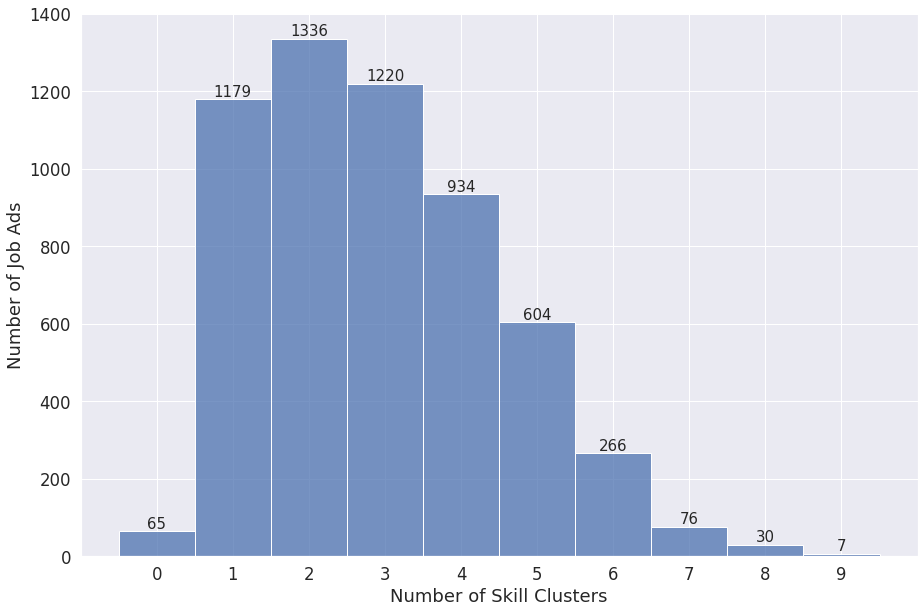

In [38]:
plot_num_clusters(df_f = cleaned_skills_clusters_df, 
                  col_f = 'total_num_clusters',
                  y_axis_label_f = 'Number of Job Ads', 
                  x_axis_label_f = 'Number of Skill Clusters', 
                  title_f = '')

In [39]:
# mean number of clusters per role
mean_clusters_per_role = cleaned_skills_clusters_df[['job_function', 'total_num_clusters']].groupby('job_function').mean().reset_index(drop = False).sort_values('total_num_clusters', ascending = False)
mean_clusters_per_role.total_num_clusters = np.round(mean_clusters_per_role.total_num_clusters, 2) 

In [40]:
mean_clusters_per_role

,job_function,total_num_clusters
1,data engineer,3.25
2,data scientist,3.16
3,machine learning engineer,2.93
0,data analyst,2.25


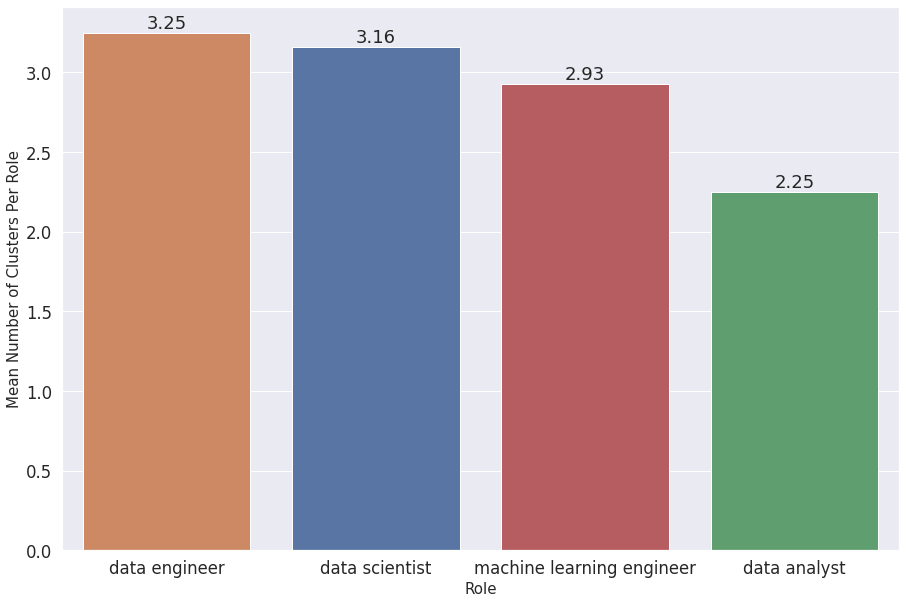

In [41]:
ax = sns.barplot(x = 'job_function', 
                 y = 'total_num_clusters', 
                 data = mean_clusters_per_role,
                palette = role_palette)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Role')  
ax.set(ylabel='Mean Number of Clusters Per Role')  
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)
fig = ax.get_figure()

# Get examples of job descriptions with many or few keyword clusters

In [42]:
def sample_high_job_descriptions(df_f, thresh_f, *args, **kwargs):
    lang_f = kwargs.get('lang_f', None)
    df_sample = df_f[df_f.total_num_clusters > thresh_f].reset_index(drop = True)
    if lang_f:
        df_sample = df_sample[df_sample.language == lang_f].reset_index(drop = True)
    print('number of relevant job ads:')
    print(df_sample.shape[0])
    df_sample = df_sample.sample(1).reset_index(drop = True)
    print('company name:')
    print(df_sample.company_name[0])
    print('job id:')
    print(df_sample.job_id[0])
    print('job title:')
    print(df_sample.job_title[0])
    print('number of clusters:')
    print(df_sample.total_num_clusters[0])
    print('job description text:')
    print(df_sample.job_description_text[0])
    # return(df_sample)                                                          
                                                                    
    

In [43]:
sample_high_job_descriptions(df_f = cleaned_skills_clusters_df,
                             thresh_f = 6,
                            lang_f = 'en')

number of relevant job ads:
85
company name:
SliceLife
job id:
eef93036acf4b1dc7b3d428aa0ffd0db
job title:
Data Scientist, Machine Learning (Belfast or Remote UK)
number of clusters:
7
job description text:
Pizza is at the heart of our communities. From birthday parties to gameday potlucks, life's special moments are bettered by the craftsmanship and tradition found behind local pizzerias' counters. We're here to make sure these iconic small businesses serve our communities for generations to come by giving them the digital tools and services commonly found at big chains. Can you imagine what a small mom and pop pizza shop could achieve with the resources of Domino's? Read more about our initiatives here. In this role, you will be one of the founding members of the Machine Learning Data Science team for our leading marketplace technology company. You will develop and implement machine learning algorithms and personalisation products from scratch that directly impact our customers. You 

In [44]:
def sample_low_job_descriptions(df_f, thresh_f, *args, **kwargs):
    lang_f = kwargs.get('lang_f', None)
    df_sample = df_f[df_f.total_num_clusters < thresh_f].reset_index(drop = True)
    if lang_f:
        df_sample = df_sample[df_sample.language == lang_f].reset_index(drop = True)
    print('number of relevant job ads:')
    print(df_sample.shape[0])
    df_sample = df_sample.sample(1).reset_index(drop = True)
    print('company name:')
    print(df_sample.company_name[0])
    print('job id:')
    print(df_sample.job_id[0])
    print('job title:')
    print(df_sample.job_title[0])
    print('number of clusters:')
    print(df_sample.total_num_clusters[0])
    print('job description text:')
    print(df_sample.job_description_text[0])
    # return(df_sample)                                                          
                                                                    
    

In [45]:
sample_low_job_descriptions(df_f = cleaned_skills_clusters_df,
                             thresh_f = 2,
                            lang_f = 'en')

number of relevant job ads:
736
company name:
Experis US, Inc
job id:
3a77c2de14c8f1cfad72a65ece2980ac
job title:
Data engineering specialist
number of clusters:
1
job description text:
- Data Engineering Specialist - Cornwall-8 months Fancy working with one of the UK's biggest names in the Communications Sector? Role: Data Engineering Specialist Contract - 8 months Start Date: ASAP Location: Cornwall About the client: Our client enables people and businesses throughout the world to realize their full potential by creating technology that transforms the way people work, play, and communicate. They develop and market software, services, and hardware that deliver new opportunities, greater convenience, and enhanced value to people's lives. Role Purpose: The role holder provide a technical skillset to support and change IT services, responsible for the ongoing support of all local, wide area and Wi-Fi networks across c.125 sites. The team maintain the customer's network infrastructure for

In [46]:
def skills_from_job_id(orig_df_f, job_id_f):
    skillz_f = orig_df_f.job_skills[orig_df_f.job_id == job_id_f]
    print([x for x in skillz_f])

In [47]:
skills_from_job_id(omnibus_jobs_df, '522e15eff8abeb544e00681bb8ed0c4c')

[['Power BI', 'Communication skills']]


In [48]:
skills_from_job_id(omnibus_jobs_df, '5fb658cd6fd72b8f9bc33fb9138c523c')

[['MATLAB', 'Power BI', 'Google AdWords', 'Azure', 'Data mining', 'Cassandra', 'WordPress', 'D3.js', 'Relational databases', 'R', 'NoSQL', 'MongoDB', 'Tableau', 'SQL', 'HBase', 'JavaScript', 'Communication skills', 'Python']]


In [49]:
def job_details_from_job_id(orig_df_f, job_id_f):
    df_select_f = orig_df_f[orig_df_f.job_id == job_id_f]
    print('company name:')
    print(df_select_f.company_name)
    print('job id:')
    print(df_select_f.job_id)
    print('job title:')
    print(df_select_f.job_title)
    print('number of clusters:')
    print(df_select_f.total_num_clusters)
    print('job description text:')
    print([x for x in df_select_f.job_description_text])
    

In [50]:
job_details_from_job_id(cleaned_skills_clusters_df, '522e15eff8abeb544e00681bb8ed0c4c')

company name:
3604    Octopus Energy Ltd 
Name: company_name, dtype: object
job id:
3604    522e15eff8abeb544e00681bb8ed0c4c
Name: job_id, dtype: object
job title:
3604    Power BI and Data Analyst
Name: job_title, dtype: object
number of clusters:
3604    1
Name: total_num_clusters, dtype: int64
job description text:
["Help us make a big green dent in the universe. We're on a mission to drive the global renewable energy revolution, and we need loads more people to help us make our vision a reality. As part of the wider Octopus Energy group, Octopus Renewables sources, invests in and actively manages a range of utility scale renewable energy assets. We are looking to expand our team as we continue to scale our investments base of c£3.5bn. Since entering the renewables market in 2010, Octopus Renewables has grown to become the largest investor of solar power in Europe and a leading investor in onshore wind. We currently manage an increasingly global portfolio of renewable energy assets.

In [51]:
job_details_from_job_id(cleaned_skills_clusters_df, '5fb658cd6fd72b8f9bc33fb9138c523c')

company name:
2487    Environmental Resources Management Group, Inc.
Name: company_name, dtype: object
job id:
2487    5fb658cd6fd72b8f9bc33fb9138c523c
Name: job_id, dtype: object
job title:
2487    NLP Data Scientist (Mid-Senior Level)
Name: job_title, dtype: object
number of clusters:
2487    7
Name: total_num_clusters, dtype: int64
job description text:
['NLP Data Scientist – Digital Services ERM is seeking a NLP Data Scientist in the UK to join our global Digital Services business. At ERM, we offer a unique combination of Environmental Health, Safety and Sustainability (EHS&S) and innovative digital solution expertise. Our Digital Services business helps organizations optimize operational performance at an accelerated pace and large scale, and achieve improvements in EHS and sustainability performance through tech-enabled innovation and digital transformation of the enterprise. A core part of the transformation is the digitization of environment, health and safety (EHS) and sustain